In [1]:
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import pandas as pd

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
"""
1. Jyothi Vishnu Vardhan Kolla
2. Vidya Ganesh

Project-5: CS-5330-> Spring 2023.
"""

import torch
import torchvision
from torchvision import datasets


data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
    (0.1307, ), (0.3081,))
])

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transform,    
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transform
)

class_names = train_data.classes

In [4]:
print(class_names)
train_dataloader = DataLoader(train_data,
                                batch_size=32,
                                shuffle=True)

test_dataloader = DataLoader(test_data,
                            batch_size=32,
                            shuffle=False)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [5]:
train_dataloader

In [17]:
import torch
from torch import nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
            in_channels=1,
            out_channels=10,
            kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(
            in_channels=10,
            out_channels=20,
            kernel_size=5,
            ),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=20 * 4 * 4, out_features=50),
            nn.Linear(50, 10)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)

        return nn.functional.log_softmax(x)

    

In [18]:
model = LeNet().to(device="mps")

In [8]:
print(model)

LeNet(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (block_2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [19]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), 
                             lr=0.1)

In [23]:
from helper_functions import accuracy_fn
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = "mps"):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        #print(y_pred)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

for i in range(5):
    train_step(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)

/var/folders/qt/lcy0bl5s105cq2bn6m_hhzlc0000gn/T/ipykernel_38918/408714485.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)


Train loss: 0.13944 | Train accuracy: 95.83%
Train loss: 0.11916 | Train accuracy: 96.48%
Train loss: 0.10596 | Train accuracy: 96.84%
Train loss: 0.10135 | Train accuracy: 96.96%
Train loss: 0.10107 | Train accuracy: 97.02%


In [4]:
dict_ = {'train_loss': [0.27054864591360095], 'train_acc': [91.66666666666667], 'test_loss': [0.07966596637933386], 'test_acc': [97.54392971246007]}
df = pd.DataFrame(dict_)
df

,train_loss,train_acc,test_loss,test_acc
0,0.270549,91.666667,0.079666,97.54393


In [6]:
import os
path = os.path.join("Models/results.csv")
df.to_csv(path)

In [20]:
df1 = pd.read_csv("Models/results.csv")
df1.head()

,Unnamed: 0,train_loss,train_acc,test_loss,test_acc
0,0,0.246825,92.501667,0.066225,97.753594
1,1,0.132994,96.013333,0.051816,98.342652
2,2,0.113442,96.655000,0.046505,98.492412
3,3,0.109930,96.701667,0.041878,98.722045
4,4,0.101617,96.945000,0.069096,97.743610


In [21]:
df1.drop("Unnamed: 0", axis=1, inplace=True)
df1

,train_loss,train_acc,test_loss,test_acc
0,0.246825,92.501667,0.066225,97.753594
1,0.132994,96.013333,0.051816,98.342652
2,0.113442,96.655000,0.046505,98.492412
3,0.109930,96.701667,0.041878,98.722045
4,0.101617,96.945000,0.069096,97.743610


In [17]:
my_dict = df1.to_dict('list')
my_dict

NameError: name 'df1' is not defined

In [31]:
model_path = "Models/base_model.pth"
from models import LeNet
from dataloader import create_dataloaders

state_dict = torch.load(model_path, map_location=torch.device('mps'))
model = LeNet()
model.load_state_dict(state_dict)

train_data, test_data, class_names = create_dataloaders(32)


In [45]:
image, labels = next(iter(test_data))

In [71]:
torch.set_printoptions(precision=2)
model.eval()
pred_labels = []
with torch.inference_mode():
    for i in range(10):
        img = image[i].unsqueeze(0)
        label = labels[i]

        prediction = model(img)
        pred_labels.append(int(torch.argmax(prediction, dim=1)))
        print(f"Prediction Probabilities are: {prediction}")
        print(f"Original label:{label}, predicted label:{torch.argmax(prediction, dim=1)}")
        print("--------------------------------------------------------------------------")


Prediction Probabilities are: tensor([[-2.38e+01, -2.25e+01, -2.00e+01, -1.73e+01, -3.27e+01, -2.52e+01,
         -3.66e+01, -1.19e-07, -2.08e+01, -1.69e+01]])
Original label:7, predicted label:tensor([7])
--------------------------------------------------------------------------
Prediction Probabilities are: tensor([[-5.95e+00, -5.88e+00, -8.33e-03, -1.13e+01, -1.55e+01, -1.85e+01,
         -5.87e+00, -2.21e+01, -1.00e+01, -2.20e+01]])
Original label:2, predicted label:tensor([2])
--------------------------------------------------------------------------
Prediction Probabilities are: tensor([[-1.28e+01, -6.61e-04, -1.12e+01, -1.38e+01, -7.65e+00, -1.14e+01,
         -9.12e+00, -1.13e+01, -1.04e+01, -1.29e+01]])
Original label:1, predicted label:tensor([1])
--------------------------------------------------------------------------
Prediction Probabilities are: tensor([[-7.40e-05, -1.89e+01, -1.15e+01, -1.66e+01, -2.13e+01, -1.51e+01,
         -9.71e+00, -1.77e+01, -1.27e+01, -1.57e+01]

/Users/jyothivishnuvardhankolla/Desktop/Project-5-DeepNetworks/models.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)


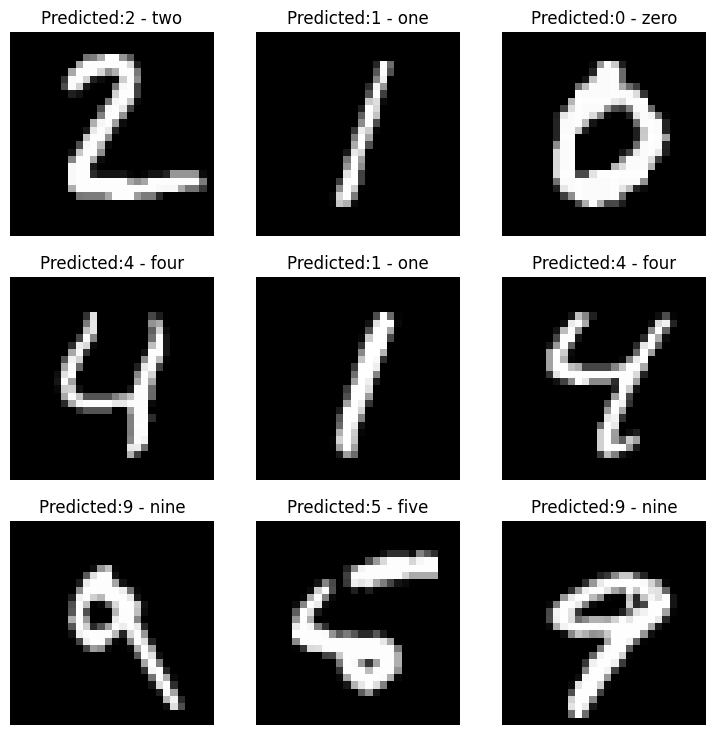

In [83]:
# Plot the predictions.
import matplotlib.pyplot as plt
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    img, label = image[i], labels[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted:{class_names[pred_labels[i]]}")
    plt.axis('off')